<a href="https://colab.research.google.com/github/joseortegalabra/Proyect-GANs/blob/master/pix2pix_facades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np


#visualizaciones entrenamiento
import time
from IPython import display

# DATA EDIFICIOS

In [2]:
#dataset de imagenes de edificios de praga - frontis
class facades():
  def __init__(self):
    url_data = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz' #link para descargar zip(gz) de las imagenes de edificios
    path_to_zip = tf.keras.utils.get_file('facades.tar.gz',  origin=url_data, extract=True)    #nombre de archivo original, path donde esta el archivo rar
    self.path = os.path.join(os.path.dirname(path_to_zip), 'facades/')     #path de las imagenes

    #hiperparametros imagenes
    self.buffer_size = 400   #cantidad de imagenes de train
    self.batch_size = 1   #una imagen por batch de acuerdo al paper  - INSTANCE NORMALIZATION
    self.img_width = 256   #pixeles finales de ancho
    self.img_height = 256  #pixeles finales de largo

  def load(self, image_file):   #funcion para leer una imagen de la base de datos desde el path y devuelve el input y el ground truth
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    #obtengo una imagen en el formato jpeg

    w = tf.shape(image)[1]    #la dimensión de ancho de la imagen    

    w = w // 2     #la mitad de la dimensión de ancho porque las imagenes tiene la real a la izquierda y el contorno a la derecha
    real_image = image[:, :w, :]       #mitad de la izquierda imagen real
    input_image = image[:, w:, :]      #mitad de la derecha imagen input (contorno del edificio)

    input_image = tf.cast(input_image, tf.float32)    #tansformar la imagen a formato de tensorflow
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

  def show_example(self, index):
    self.input_example, self.real_example = self.load(self.path + 'train/' + str(index) + '.jpg')

    #mostra imagen random de train
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = ((10,10)))
    axs[0].imshow(self.input_example/255.)  #normalizar a [0,1] para visualizar
    axs[0].axis('off')
    axs[0].set_title('Input Image [' + str(index) + ']')

    axs[1].imshow(self.real_example/255.)
    axs[1].axis('off')
    axs[1].set_title('Ground truth [' + str(index) + ']')
    plt.show()

  # funciones de data augmentation
  def resize(self, input_image, real_image, height_resized, width_resized):    #funcion para redimensionar la imagen
    input_image = tf.image.resize(input_image, [height_resized, width_resized], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height_resized, width_resized], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

  def random_crop(self, input_image, real_image):    #funcion para recortar la imagen de forma aleatoria
    stacked_image = tf.stack([input_image, real_image], axis=0)    #aplicar las 2 imaggenes input y real data
    cropped_image = tf.image.random_crop(stacked_image, size=[2, self.img_height, self.img_width, 3])      #recortar en 2 imagenes de 3 canales y ancho y alto final definido  
    return cropped_image[0], cropped_image[1]

  def random_mirror(self, input_image, real_image):      # random mirror p = 0.5
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

  def normalize(self, input_image, real_image):   # normalizar imagenes, el input y el real a una escala [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image


  @tf.function()
  def random_jitter(self, input_image, real_image):   #hacer las transformaciones del nerviosismos, redimencionar a una dimension más grande y luego recortar a forma aleatoria y luego random flip
    # resizing to 286 x 286 x 3  - aumentar la dimension
    input_image, real_image = self.resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = self.random_crop(input_image, real_image)

    # random reflejar horizontal o vertical
    input_image, real_image = self.random_mirror(input_image, real_image)

    return input_image, real_image

  def show_example_data_augmentation(self):    #mostrar la imagen de ejemplo con data augmentation
    plt.figure(figsize=(10, 10))
    fig, axs = plt.subplots(4, 2, figsize = ((15,15)))

    for i in range(4):
      input_example_augmentation, real_example_augmetation = self.random_jitter(self.input_example, self.real_example)
      axs[i][0].imshow(input_example_augmentation/255.)   #mismo tengo que rescalar la imagen a [0, 1] para graficar con plt
      axs[i][0].axis('off')

      axs[i][1].imshow(real_example_augmetation/255.)
      axs[i][1].axis('off')


  #crear funcion para pasar desde el path hasta la imagen procesada
  def load_image_train(self, image_file):   
    '''
    crear una funcion que se aplica a todo el data set original, entrada es el path de una imagen original y la salida son input y 
    ground truth con las transformaciones de data agmentation de la imagen leida - Conjunto de TRAIN
    '''
    input_image, real_image = self.load(image_file)   #leo la imagen desde el path y devuelvo la imagen original imput y original real
    input_image, real_image = self.random_jitter(input_image, real_image)   #hago las transformaciones de data augmentation 
    input_image, real_image = self.normalize(input_image, real_image)   #normalizo la imagen -1, 1
    return input_image, real_image
  

  #misma funcion toma el path de una imagen de test y la procesa
  def load_image_test(self, image_file):   
    '''
    Funcion a aplicar a todo el dataset, toma el path de la imagen y devuelve la imagen normalizada - Anagolo a la otra función de train - Conjunto de TEST
    '''
    input_image, real_image = self.load(image_file)  #leo la imagen desde el path y devuelvo la imagen original imput y original real
    #input_image, real_image = self.resize(input_image, real_image, self.img_height, self.img_width)      # originalmente ya esta en 256 pero se usa la funcion para dejarlo en un formato imagen de TF
    input_image, real_image = self.normalize(input_image, real_image)  #SOLO normalizar las imagenes de test
    return input_image, real_image


  def create_dataset_train(self):
    train_dataset = tf.data.Dataset.list_files(self.path+'train/*.jpg')   #creo dataset de TF con el path de todas las imagenes del conjunto de train
    train_dataset = train_dataset.map(self.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)   #funcion map aplica a todo el Dataset, lee la imagen desde el path y devuelve input y ground truth
    train_dataset = train_dataset.shuffle(self.buffer_size)    #shuffle de los datos
    train_dataset = train_dataset.batch(self.batch_size)  #extraer batches de tamaño 1   
    return train_dataset
  
  def create_dataset_test(self):
    test_dataset = tf.data.Dataset.list_files(self.path+'test/*.jpg')      #crear dataset de test - CON LOS ARCHIVOS ORIGINALES de TEST
    test_dataset = test_dataset.map(self.load_image_test)    #aplicar la funcion de separar las imagenes y escalar
    test_dataset = test_dataset.batch(self.batch_size)   #obtener batches para test - batch tamaño 1
    return test_dataset

In [3]:
#create class data
data_facades = facades()

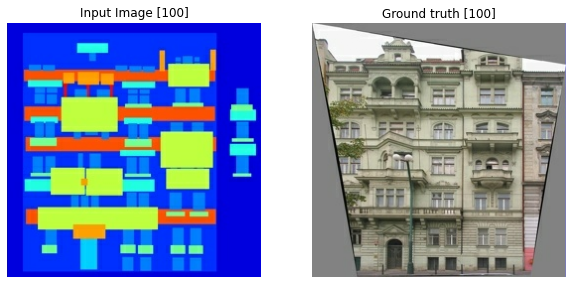

EXAMPLE - random image TRAIN


In [4]:
#show image random
data_facades.show_example(np.random.randint(data_facades.buffer_size))
print('EXAMPLE - random image TRAIN')

EXAMPLE - Data Augmentation TRAIN


<Figure size 720x720 with 0 Axes>

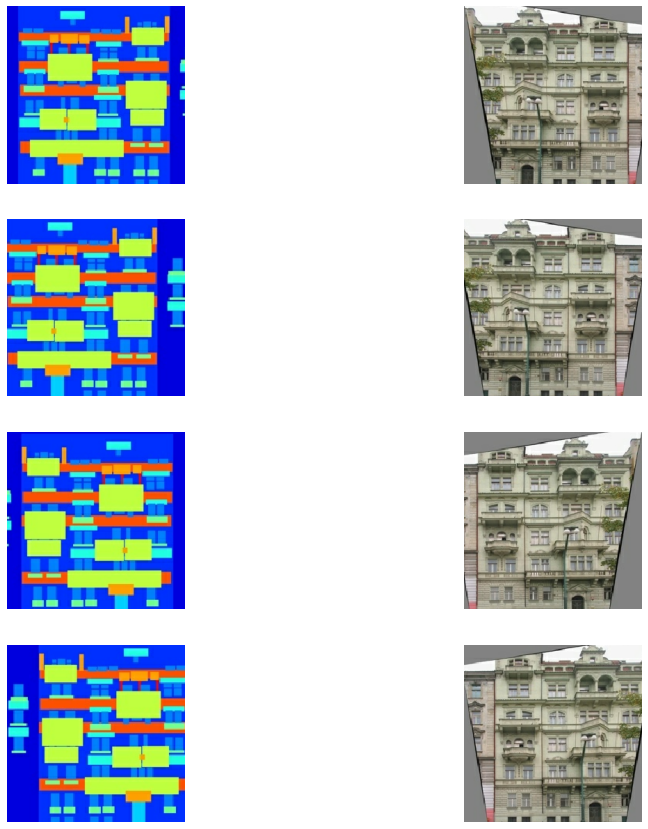

In [5]:
#show data augmentation
data_facades.show_example_data_augmentation()
print('EXAMPLE - Data Augmentation TRAIN')

In [6]:
#crear dataset de tensorflow para train
X_train = data_facades.create_dataset_train()
X_train

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [7]:
#crear dataset de tensorflow para test
X_test = data_facades.create_dataset_test()
X_test

<BatchDataset shapes: ((None, None, None, None), (None, None, None, None)), types: (tf.float32, tf.float32)>

# PIX2PIX

# Crear generator

In [8]:
#padding 'same', calculos de tamaño de imagen desde documentos oficiales de TF
#altura_salida = ceil(float(altura_entrada) / float(tamaño_stride[1]))
#ancho_salida  = ceil(float(ancho_entrada) / float(tamaño_stride[2]))

In [9]:
class pix2pix():
  def __init__(self):
    self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)    #crear funcion de perdida binaria para evaluar loss GAN
    
    self.initializer = tf.random_normal_initializer(0., 0.02)     #inicializar los pesos de las capas conv2d, mismo valor que los demas
    
    self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)   #definir optimizadores para el generador y el discriminador
    self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    self.epochs = 150    #cantidad de epocas

  def downsample(self, filters, size, apply_batchnorm=True):     
    '''
    crear capa convolusional encoder - reducir dimensionalidad de la imagen.   Crear un modelo secuencial donde solo tiene una capa CONV2D
    Cantidad de filtros y tamaño variable. Stride fijo a 2. Padding = 'same'   -> siempre se reduce a la mitad el tamaño de la imagen (ancho y alto)
    Reducir dimensionalidad usado en generador y discriminador
    (Modelo Secuencial de keras: Sequential groups a linear stack of layers into a tf.keras.Model)
    '''

    result = tf.keras.Sequential()     #Sequential groups a linear stack of layers into a tf.keras.Model. -> Puedo agrupar varias capas de keras y me devuelve las capas unidas y permitiendo unirlas a otras capas de keras
    result.add( tf.keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, padding='same', kernel_initializer= self.initializer, use_bias=False))       
    
    if apply_batchnorm:
      result.add(tf.keras.layers.BatchNormalization())   #aplicar batch normalization en el layer de salida

    result.add(tf.keras.layers.LeakyReLU())   #aplicar funcion de activacion

    return result    #retorna el conjunto de capas CONV2D, batch_normalization y activacion unidas y que se pueden unir a otras capas


  def upsample(self, filters, size, apply_dropout=False):
    '''
    crear capa convolusional decoder - aumentar dimensionalidad de la imagen.   Crear un modelo secuencial donde solo tiene una capa CONV2D TRASPUESTA
    Cantidad de filtros y tamaño variable. Stride fijo a 2. Padding = 'same'   -> siempre aumenta al doble el tamaño de la imagen (ancho y alto)
    Aumentar la dimensionalidad usado en generador - Crear imagen ficticia a partir del INPUT y de RUIDO GAUSIANO
    '''  

    result = tf.keras.Sequential()   
    result.add(tf.keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, padding='same', kernel_initializer = self.initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())   #siempre se aplica batch normalization

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))   #aplicar dropout con probabilidad 0.5  -> RUIDO GAUSIANO

    result.add(tf.keras.layers.ReLU())

    return result    #return es el modelo creado con la capa convolusion traspuesta con ruido gausiano, batch_normalization y relu

  
  def create_generator(self):  
    inputs = tf.keras.layers.Input(shape=[256,256,3])       #crear layer input de tamaño 256x256x3 obtenido del preprocesamiento

    #definir lista con la capas convolusionales encoder de la U-NET
    down_stack = [
      self.downsample(64, 4, apply_batchnorm=False),         #(None, 128, 128, 64)   cada capa me reduce a la mitad la dimensión
      self.downsample(128, 4),                               #(None, 64, 64, 128)
      self.downsample(256, 4),                               #(None, 32, 32, 256)
      self.downsample(512, 4),                               #(None, 16, 16, 512)
      self.downsample(512, 4),                               #(None, 8, 8, 512)
      self.downsample(512, 4),                               #(None, 4, 4, 512)
      self.downsample(512, 4),                               #(None, 2, 2, 512)
      self.downsample(512, 4),                               #(None, 1, 1, 512)    #reduzo el espacio latente al ancho y alto más pequeño posible  
    ]

    #definir lista con las capas de deconvolusión decoder de la U-NET
    up_stack = [
      self.upsample(512, 4, apply_dropout=True),             # (None, 2, 2, 1024)     #duplico ancho y alto. DUPLICO CANTIDAD DE FILTROS al utilizar los valores del encoder   
      self.upsample(512, 4, apply_dropout=True),             # (None, 4, 4, 1024)      
      self.upsample(512, 4, apply_dropout=True),             # (None, 8, 8, 1024)
      self.upsample(512, 4),                                 # (None, 16, 16, 1024)
      self.upsample(256, 4),                                 # (None, 32, 32, 512)
      self.upsample(128, 4),                                 # (None, 64, 64, 256)
      self.upsample(64, 4),                                  # (None, 128, 128, 128)    #aumento la dimensionalidad hasta el paso anterior a tener la imagen original 256x256
    ]

    #ultima capa decoder -> (None, 256, 256, 3) y ahora con funcion de activacion tangente hiperbolica
    last_decoder = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 4, strides=2, padding='same', kernel_initializer= self.initializer,  activation='tanh') 



    #---->UNIR CAPAS PARA ARMAR GENERADOR U-NET-----<
    x = inputs    #capa de entrada

    #ENCODER
    results_encoder = []    #voy guardando los resultados de las capas de encoder
    for down in down_stack:   #recorro el array con las capas de downsaple
      x = down(x)    #obtengo la salida de pasar por la capa encoder
      results_encoder.append(x)    #guardo los resultados de pasar por cada una de las capas de downsample
    results_encoder = reversed(results_encoder[:-1])    #invierto el orden de los valores y elimino los resultados de la capa (None, 1, 1, 512)    

    #DECODER
    for up, result_encoder in zip(up_stack, results_encoder):    #hago de upsample considerando el valor obtenido al pasar por cada capa encoder y el paso por cada capa decoder
      x = up(x)    #obtengo la salida al pasar por la capa decoder
      x = tf.keras.layers.Concatenate()([x, result_encoder])    #apilar los resultados de downsampling con los de upsampling
    x = last_decoder(x)    #paso por la ultima capa para obtener la imagen deseada que va al discriminador

    self.generator = tf.keras.Model(inputs=inputs, outputs=x)
    


  def create_discriminator(self):
    '''
    Discriminador lee la imagen input y la imagen real y devuelve una matriz 30x30 que me permite clasificar si la imagen es real o falsa
    '''

    input = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')   #input contorno 
    target = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')  #imagen real

    #red discriminador
    x = tf.keras.layers.concatenate([input, target])          # (None, 256, 256, channels*2 -> 6)   #unir input y la imagen real
    x = self.downsample(64, 4, apply_batchnorm=False)(x)      # (None, 128, 128, 64)  #crear capa downsample y evaluarla inmediatamente en x input
    x = self.downsample(128, 4)(x)                            # (None, 64, 64, 128)
    x = self.downsample(256, 4)(x)                            # (None, 32, 32, 256) 
    
    #nueva capa zero padding
    x = tf.keras.layers.ZeroPadding2D()(x)                # (None, 34, 34, 256)     agregar vector de ceros a todos los lados
    
    #nueva capa de convlusion downsample con padding valid, batchnormalizacion y activacion leakyrelu      tamaño: [(34 - filtro - 0) / stride]  + 1  
    x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 4, strides= 1, kernel_initializer= self.initializer, use_bias=False)(x)# (None, 31, 31, 512)   
    x = tf.keras.layers.BatchNormalization()(x)   
    x = tf.keras.layers.LeakyReLU()(x)

    #nueva capa zero padding
    x = tf.keras.layers.ZeroPadding2D()(x)                  # (None , 33, 33, 512)

    #nueva capa y ultima convolsion con padding valid, sin batchnormalization y sin activacion ?     tamaño = [(33 - filtro + 0) / stride] + 1
    x = tf.keras.layers.Conv2D(filters = 1, kernel_size = 4, strides=1, kernel_initializer=self.initializer)(x) # (None, 30, 30, 1) 

    #return el model de keras con el input y el output
    self.discriminator = tf.keras.Model(inputs=[input, target], outputs=x)



  def generator_loss(self, discriminator_generated_output, generated_output, real_image):   
    self.LAMBDA = 100    #parametro fijado en el paper - para penalizar norma l1 en la funcion de costos total de la GAN
    '''
    Loss del Generador. 
    gan loss = valor 1 contra el valor obtenida en el discriminador de la imagen obtenida en el generador - que tanto engañe al discriminador con la imagen ficticia
    l1 loss = Imagen real vs imagen obtenida del generador
    Generador busca minimizar su loss, que la imagen ficticia sea clasificada como real.
    '''

    #comparo valor 1 que el discriminador cree que la imagen es real contra el valor obtenido en el discriminador de la imagen fictia
    gan_loss = self.loss_object(tf.ones_like(discriminator_generated_output),   discriminator_generated_output)
    
    #norma 1 entre la imagen real y la imagen obtenida en el generador
    l1_loss = tf.reduce_mean(tf.abs(real_image - generated_output))

    #perdida del generador es la suma de la tipica perdida de la gan más la perdida con la norma l1
    total_gen_loss = gan_loss + (self.LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

  def discriminator_loss(self, discrimator_real_output, discriminator_generated_output):
    '''
    Loss del Discriminador.
    real_loss = valor 1 (es una imagen real) contra valor obtenido al pasar la imagen real por el discriminador
    generated_loss = valor 0  (es una imagen ficticia) contra valor obtenido al pasar la imagen generada por el discriminador.
    Discriminador busca minimizar su loss, que la imagen real sea clasificada como real y que la imagen ficitia sea clasificada como ficticia
    '''
    real_loss = self.loss_object(tf.ones_like(discrimator_real_output), discrimator_real_output)

    generated_loss = self.loss_object(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


  def generate_images(self, test_input, test_real, save_results = False, index_file = 0): 
    '''
    Funcion creada para mostrar avances de entrenamiento del modelo con una imagen del conjunto de test
    Mostrar input, ground truth, generated
    '''

    #generated_image = self.generator(test_input, training=True)    #especificado por qué le ponen TRUE 
    generated_image = self.generator(test_input, training=False)

    #graficar
    fig = plt.figure(figsize=(15,15))

    #IMAGEN A MOSTRAR DURANTE EL ENTRENAMIENTO ES LA PRIMERA IMAGEN DEL CONJUNTO DE TEST - PERO ESTA VIENE DEL DATASET Y POR LO TANTO REORDENA LA IMAGEN Y SOLO ME ENTREGA UNA IMAGEN CUALQUIERA
    display_list = [test_input[0], test_real[0], generated_image[0]]   #eliminar dimensiones para graficar
    
    title = ['Input Image', 'Ground Truth', 'Generated Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()
    
    if(save_results):
      fig.savefig(str(index_file), dpi = 150)

  def generate_images_discriminator(self, test_input, test_real, save_results = False, index_file = 0):
    #generated_image = self.generator(test_input, training=True)    #especificado por que le ponen TRUE 
    generated_image = self.generator(test_input, training=False)    #especificado por que le ponen TRUE 
    discriminator_generated_image = self.discriminator([test_input, generated_image], training = False)

    discriminator_ground_truth =  self.discriminator([test_input, test_real], training = False)

    display_list = [discriminator_generated_image, discriminator_ground_truth]
    title = ['Discriminator Generated Image', 'Discriminator Ground Truth']

    fig = plt.figure(figsize=(8,8))
    for i in range(2):
      plt.subplot(2, 1, i+1)
      plt.title(title[i])
      #mostrar resultado discriminador de imagen ficticia y real
      plt.imshow(display_list[i][0,...,-1], vmin=0, vmax=1, cmap='RdBu_r')
      plt.colorbar()
      plt.axis('off')
    #plt.colorbar()
    plt.show()

    if(save_results):
      fig.savefig(str(index_file), dpi = 150)

  def create_checkpoint(self):
    self.checkpoint_dir = './training_checkpoints'
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(generator_optimizer=      self.generator_optimizer,
                                          discriminator_optimizer=  self.discriminator_optimizer,
                                          generator    =            self.generator,
                                          discriminator=            self.discriminator)
    
  @tf.function
  def train_step(self, input_image, real_image):
    #entrenar con gradient tape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      #crear imagen ficticia a partir de una imagen de input
      gen_output = self.generator(input_image, training=True)

      #discriminador de la imagen input con la imagen real
      disc_real_output = self.discriminator([input_image, real_image], training=True)
      #discriminador de la imagen input con la imagen generada en el generador
      disc_generated_output = self.discriminator([input_image, gen_output], training=True)

      #calcular la loss del generador
      self.gen_total_loss, self.gen_gan_loss, self.gen_l1_loss = self.generator_loss(disc_generated_output, gen_output, real_image)
      # calcular la loss de discriminador
      self.disc_total_loss = self.discriminator_loss(disc_real_output, disc_generated_output)

    
    #---->entrenar la red con los gradientes
    #calcular gradientes del generador
    generator_gradients = gen_tape.gradient(self.gen_total_loss, self.generator.trainable_variables)
    #calcular gradientes del discriminador
    discriminator_gradients = disc_tape.gradient(self.disc_total_loss, self.discriminator.trainable_variables)

    #----->aplicar gradiente en el generador
    self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))


  #funcion para entrenar
  def fit(self, train_ds, test_ds):
    #self.history_gen_total_loss = []
    #self.history_gen_gan_loss = []
    #self.history_gen_l1_loss = []
    #self.history_disc_total_loss = []

    for epoch in range(self.epochs):
      start = time.time()
      display.clear_output(wait=True)

      #Ejemplo de una imagen del set de TEST por época
      for example_input, example_target in test_ds.take(1):    #tomo una sola imagen del dataset de test
        self.generate_images(example_input, example_target, save_results = True, index_file = 'Output, epoch: ' +str(epoch))
        self.generate_images_discriminator(example_input, example_target, save_results = True, index_file = 'Output Discriminator, epoch: ' +str(epoch))
      print("Epoch: ", epoch)

      # Entrenar el modelo  - TRAIN
      for n, (input_image, target) in train_ds.enumerate():
        print('.', end='')    #barra progreso
        if (n+1) % 100 == 0:
          print()
        self.train_step(input_image, target)  #entrenar la red con BATCH TAMAÑO 1
      print()

      #guardar losses en cada epoca
      #self.history_gen_total_loss.append(self.gen_total_loss)  
      #self.history_gen_gan_loss.append(self.gen_gan_loss)
      #self.history_gen_l1_loss.append(self.gen_l1_loss)
      #self.history_disc_total_loss.append(self.disc_total_loss) 

      # guardar checkpoint del modelo cada 20 epocas
      if (epoch + 1) % 20 == 0:
        self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)

In [10]:
model_gan = pix2pix()     #crear objeto modelo

### Generator

In [11]:
model_gan.create_generator()    #crer modelo generador
model_gan.generator

In [12]:
#GRÁFICO donde muestra mi modelo generador
#tf.keras.utils.plot_model(model_gan.generator, to_file='model_generator.png', show_shapes=True, dpi=150)

### Discriminator
The Discriminator is a PatchGAN.
Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
The shape of the output after the last layer is (batch_size, 30, 30, 1)
Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
Discriminator receives 2 inputs.
Input image and the target image, which it should classify as real.
Input image and the generated image (output of generator), which it should classify as fake.
We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [13]:
model_gan.create_discriminator()   #crear modelo discriminador
model_gan.discriminator

In [14]:
#VISUALIZAR DISCRIMINADOR
#tf.keras.utils.plot_model(model_gan.discriminator, to_file= 'model_discriminator.png', show_shapes=True, dpi=150)

#Pasar el input de la imagen de ejemplo por el generador y su salida por el discriminador

INPUT

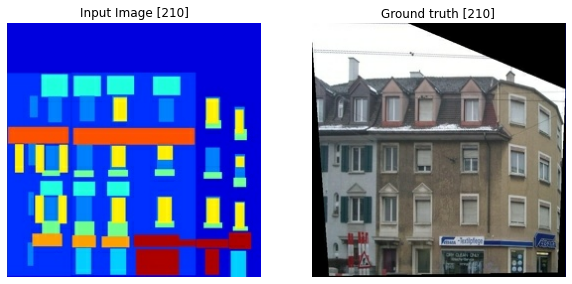

In [15]:
data_facades.show_example(np.random.randint(data_facades.buffer_size))

GENERATOR

In [16]:
#pasar el input de ejemplo por el generador
example_generator = model_gan.generator(data_facades.input_example[tf.newaxis, ...], 
                                        training=False)

In [17]:
example_generator.shape

TensorShape([1, 256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

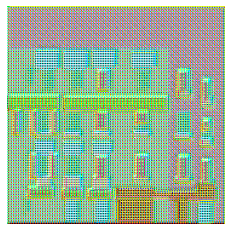

In [18]:
plt.imshow(example_generator[0, ...])
plt.axis('off')

DISCRIMINATOR - generated image

In [19]:
#Ejemplo pasar la imagen generada en el generador al discriminador y este decida si es verdadera o falsa
#entrada al discriminador es el input (silueta) y la imagen a evaluar
example_discriminator_generated = model_gan.discriminator(  [data_facades.input_example[tf.newaxis, ...], example_generator]  ,#se pasa como lista 
                                                            training = False
                                                          )  

In [20]:
example_discriminator_generated.shape

TensorShape([1, 30, 30, 1])

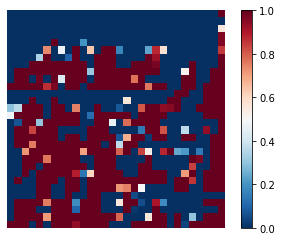

In [21]:
plt.imshow(example_discriminator_generated[0,...,-1], vmin=0, vmax=1, cmap='RdBu_r')      #[0,...,-1]  elimina primera y ultima dimension
plt.colorbar()
plt.axis('off')
plt.show()

DISCRIMINATOR - ground truth

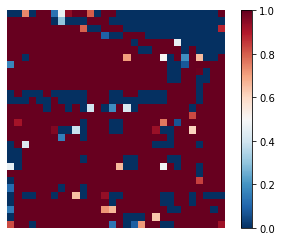

In [22]:
example_discriminator_ground_truth = model_gan.discriminator(  [data_facades.input_example[tf.newaxis, ...], data_facades.real_example[tf.newaxis, ...]] ,
                                                            training = False  )

plt.imshow(example_discriminator_ground_truth[0,...,-1], vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()
plt.axis('off')
plt.show()

In [23]:
model_gan.discriminator_loss(example_discriminator_ground_truth, example_discriminator_generated)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4821243>

In [24]:
model_gan.generator_loss(example_discriminator_generated, example_generator, data_facades.real_example[tf.newaxis, ...] )

(<tf.Tensor: shape=(), dtype=float32, numpy=11282.072>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.9411007>,
 <tf.Tensor: shape=(), dtype=float32, numpy=112.80131>)

# Generate Images

Write a function to plot some images during training.

We pass images from the test dataset to the generator.
The generator will then translate the input image into the output.
Last step is to plot the predictions and voila!
Note: The training=True is intentional here since we want the batch statistics while running the model on the test dataset. If we use training=False, we will get the accumulated statistics learned from the training dataset (which we don't want)

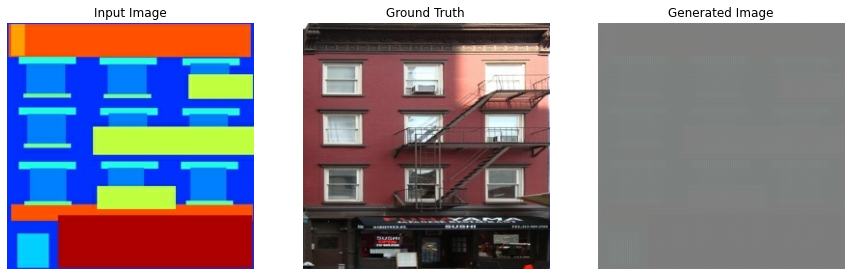

In [25]:
#Ejemplo de como se ve la primera imagen de test
for example_input, example_target in X_test.take(1):    #tomar una imagen desde el conjunto de dataset de test
  model_gan.generate_images(example_input, example_target)    #llamar la funcion con la imagen extraida desde dataset de TEST

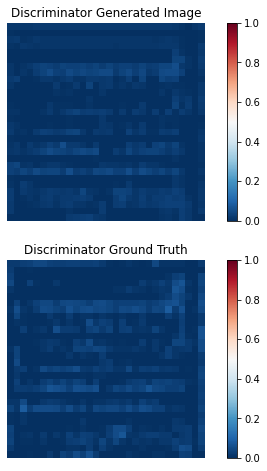

In [26]:
for example_input, example_target in X_test.take(1):
  model_gan.generate_images_discriminator(example_input, example_target)

# Training

For each example input generate an output.
The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
Next, we calculate the generator and the discriminator loss.
Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
Then log the losses to TensorBoard.

In [27]:
#crear los checkpoint 
model_gan.create_checkpoint()


The actual training loop:

Iterates over the number of epochs.
On each epoch it clears the display, and runs generate_images to show it's progress.
On each epoch it iterates over the training dataset, printing a '.' for each example.
It saves a checkpoint every 20 epochs.


This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

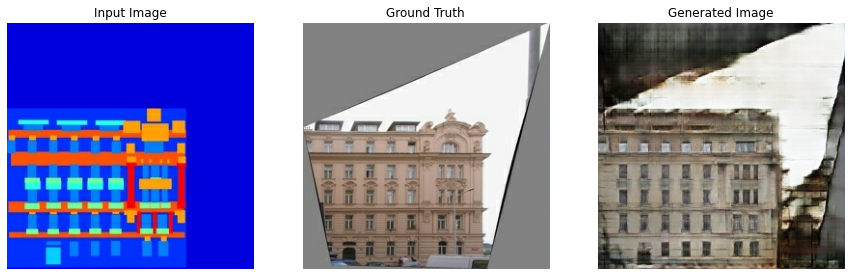

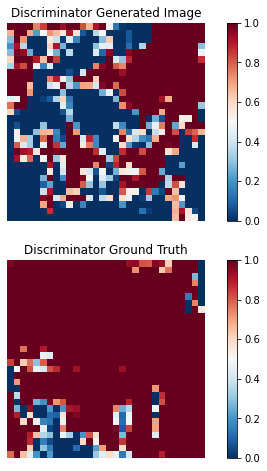

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 67.92524671554565 sec



NameError: ignored

In [28]:
#entrenar el mdelo
model_gan.fit(X_train, X_test)   #paso un dataset para entrenar

# Restore the latest checkpoint and test

In [ ]:
!ls {model_gan.checkpoint_dir}

In [ ]:
#restoring the latest checkpoint in checkpoint_dir
model_gan.checkpoint.restore(tf.train.latest_checkpoint(model_gan.checkpoint_dir))

# Generate using test dataset

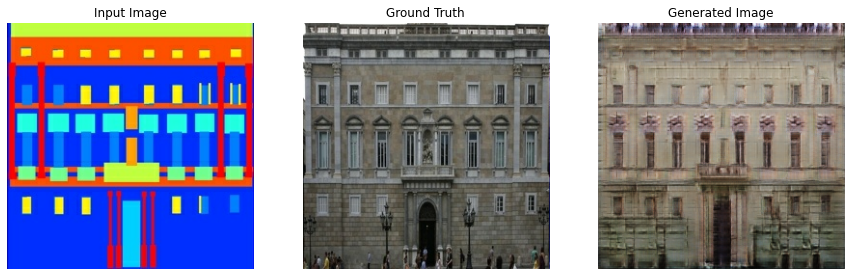

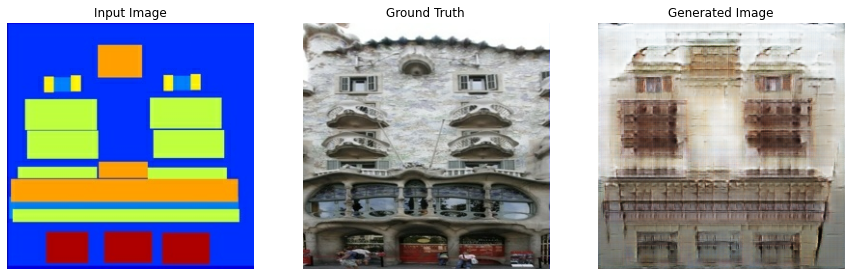

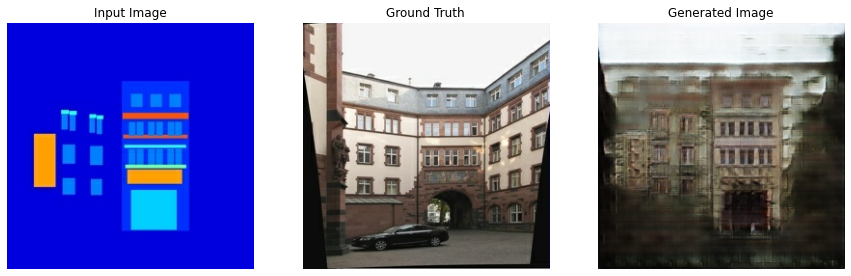

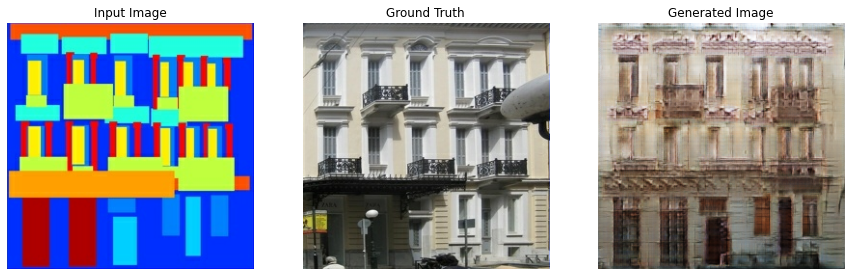

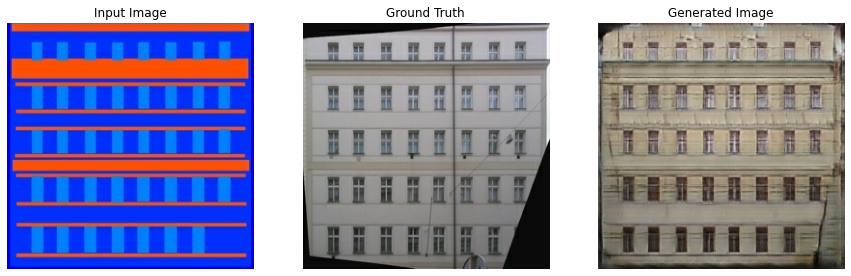

In [29]:
# Run the trained model on a few examples from the test dataset
for i, (inp, tar) in enumerate(X_test.take(5)):
  model_gan.generate_images(inp, tar, save_results= True, index_file = 'Test00' + str(i) )

In [ ]:
model_gan.history_gen_total_loss

In [ ]:
model_gan.history_disc_total_loss

In [ ]:
model_gan.total_gen_loss_np

In [ ]:
plt.plot()